In [1]:
from MClique import generate_clustered_network, perform_bond_percolation, keep_clusters_with_node_swap, generate_clustered_network_discrete_M,perform_percolation, gillespie_SIR
import numpy as np
import random
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm
import matplotlib.tri as tri
import igraph as ig
from joblib import Parallel, delayed
import numba
from numba import njit

#from scipy.interpolate import interp1d

%matplotlib ipympl

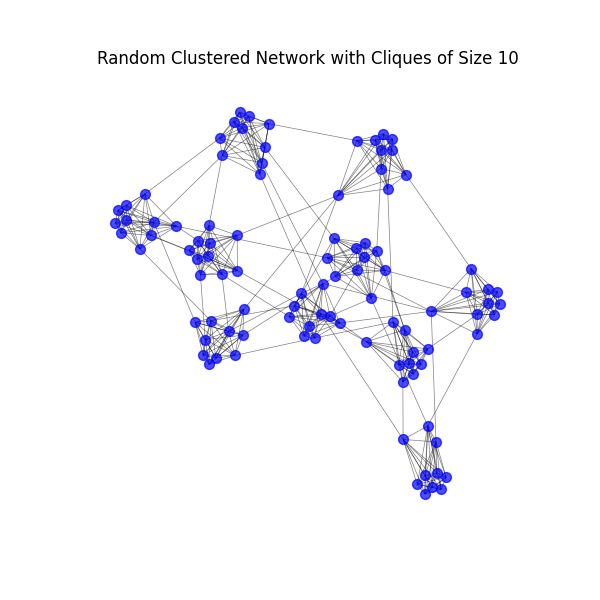

In [2]:
#An example of the network
N = 100   # Number of nodes in the network
M = 10 # Size of the cliques

# Generate the adjacency matrix
adj_matrix, cliques = generate_clustered_network_discrete_M(N, M, lambda_edges= 1, m_cliques= 1)
#adj_matrix = keep_clusters_with_node_swap(adj_matrix, cliques, s_f = 0.5, H = 0.9)
# Create a NetworkX graph for visualization
G = nx.from_numpy_array(adj_matrix)

# Draw the network
plt.figure(figsize=(6, 6))
pos = nx.spring_layout(G, iterations=100)

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=50, node_color='blue', alpha=0.7)

# Draw edges
nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.5)

plt.axis('off')
plt.title(f'Random Clustered Network with Cliques of Size {M}')
plt.show()

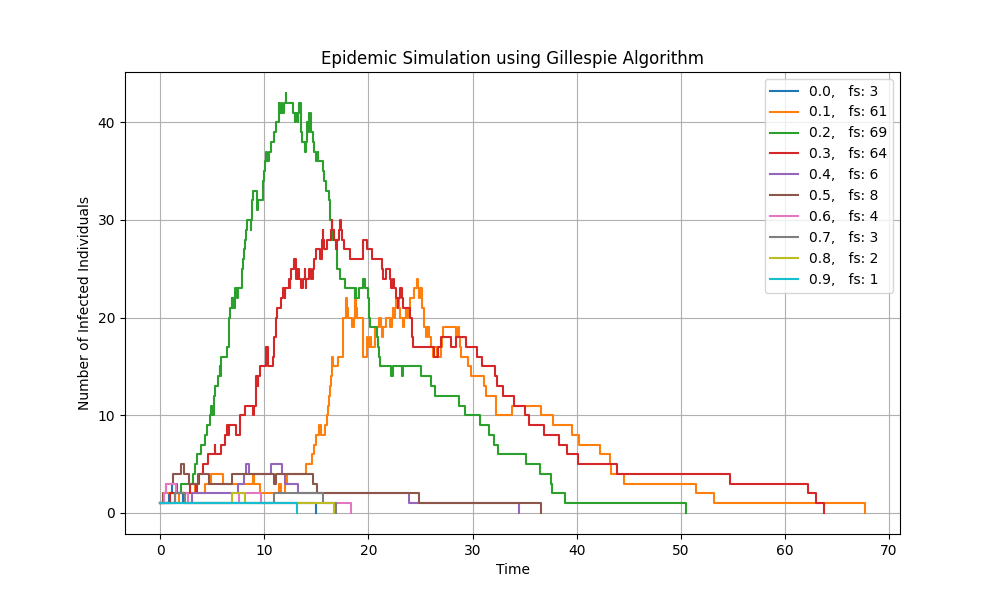

In [14]:
# Generate a network
N = 1000  # Number of nodes
M = 3     # Clique size
lambda_edges = 2.5
lambda_cliques = 5.0


beta = 0.3   # Infection rate
gamma = 0.1  # Recovery rate
r0 = beta/gamma

adj_matrix, cliques = generate_clustered_network(N, M, lambda_edges, lambda_cliques)

plt.figure(figsize=(10, 6))

H_range = np.arange(0,1,0.1)
fs = []
for i in H_range:
    adj_matrix_red = keep_clusters_with_node_swap(adj_matrix, cliques, s_f = 0.02, H = i)

    # Set epidemic parameters

    initial_infected = [random.randint(0, np.shape(adj_matrix_red)[0]-1)]# Random initial infected node
    max_time = 160

    # Run the Gillespie simulation
    times, num_infected, final_size = gillespie_SIR(adj_matrix_red, beta, gamma, initial_infected, max_time)

    fs.append(final_size)

    plt.step(times, num_infected, where='post', label = str(round(i,2)) + f",   fs: {final_size}")
plt.xlabel('Time')
plt.ylabel('Number of Infected Individuals')
plt.title('Epidemic Simulation using Gillespie Algorithm')
plt.grid()
plt.legend()
plt.show()

In [30]:

# Parameters for the network
N = 1000   # Total number of nodes
M = 3     # Size of cliques
lambda_edges = 2
m_cliques = 2

# Epidemic parameters
beta = 4   # Infection rate
gamma = 2  # Recovery rate

max_time = 300.0

# Ranges for s_f and H
s_f_values = np.linspace(0.0, 1.0, 41)[1:]  # From 0.025 to 0.5 in step
H_values = np.linspace(0.0, 1.0, 41)        # From 0 to 1 in steps of 0.05

# Number of runs where we generate new network
N_runs = 20

# Precompute meshgrid for plotting
X, Y = np.meshgrid(s_f_values, H_values)

# Initialize arrays to store results
fraction_susceptible = np.zeros((len(H_values), len(s_f_values)))
final_sizes = np.zeros((len(H_values), len(s_f_values), N_runs))

# Function to process a single combination of H and s_f
def process_single_run(k):
    np.random.seed(k)  # Ensure different random seed for each run
    # Generate the initial network
    adj_matrix, cliques = generate_clustered_network_discrete_M(
        N, M, lambda_edges=lambda_edges, m_cliques=m_cliques
    )

    # Arrays to store results for this run
    final_sizes_run = np.zeros((len(H_values), len(s_f_values)))
    fraction_susceptible_run = np.zeros((len(H_values), len(s_f_values)))

    for i, H in enumerate(H_values):
        for j, s_f in enumerate(s_f_values):
            # Generate the reduced network
            adj_matrix_red = keep_clusters_with_node_swap(adj_matrix, cliques, s_f=s_f, H=H)
            num_nodes_red = adj_matrix_red.shape[0]
            fraction_susceptible_run[i, j] = num_nodes_red / N

            if num_nodes_red == 0:
                final_size = 0
            else:
                # Pick a random susceptible node to infect initially
                initial_infected_red = [np.random.randint(0, num_nodes_red)]
                # Run the Gillespie simulation
                times, num_infected, final_size = gillespie_SIR(
                    adj_matrix_red, beta, gamma, initial_infected_red, max_time
                )
            # Record the final epidemic size
            final_sizes_run[i, j] = final_size / num_nodes_red if num_nodes_red > 0 else 0.0

    return fraction_susceptible_run, final_sizes_run

# Parallel computation using joblib
results = Parallel(n_jobs=-1)(
    delayed(process_single_run)(k) for k in range(N_runs)
)

# Aggregate results
for k, (fraction_susceptible_run, final_sizes_run) in enumerate(results):
    fraction_susceptible += fraction_susceptible_run
    final_sizes[:, :, k] = final_sizes_run

# Compute the average fraction of susceptible nodes
fraction_susceptible /= N_runs

# Compute the average final sizes over runs
average_final_sizes = np.mean(final_sizes>0.05, axis=2)

# Create the contour/heatmap plot
plt.figure(figsize=(8, 6))
cp = plt.contourf(X, Y, average_final_sizes, levels=30, cmap='viridis')
plt.colorbar(cp, label='Final Epidemic Size (Fraction of Population)')
plt.vlines(gamma / beta, Y.min(), Y.max(), color="red", label=r"$\gamma / \beta$")
plt.xlabel('Fraction of Clusters Kept (s_f)')
plt.ylabel('H')
plt.title('Final Epidemic Size for Varying $s_f$ and $H$')
plt.legend()
plt.show()


plt.figure()
plt.imshow(np.flipud(average_final_sizes))
plt.show()

KeyboardInterrupt: 

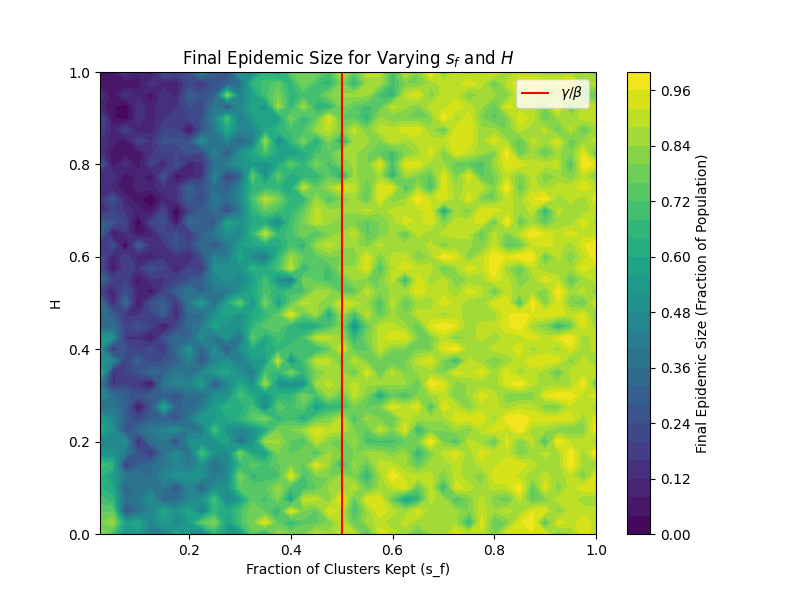

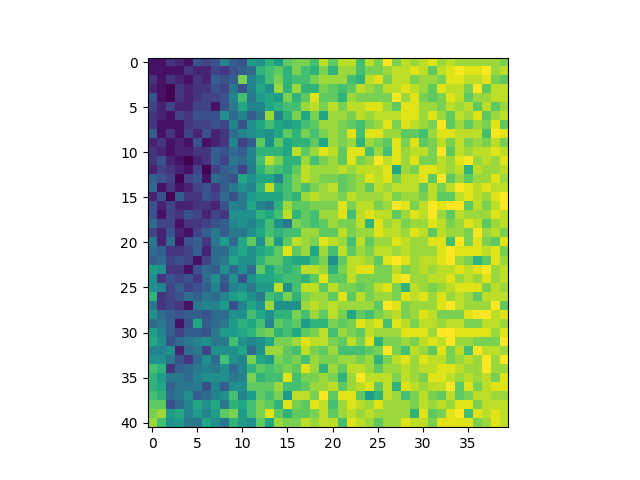

In [29]:

# Parameters for the network
N = 500   # Total number of nodes
M = 3    # Size of cliques
lambda_edges = 1
m_cliques = 2

# Epidemic parameters
beta = 4   # Infection rate
gamma = 2  # Recovery rate

max_time = 160.0

# Ranges for s_f and H
s_f_values = np.linspace(0.0, 1.0, 41)[1:]  # From 0.025 to 0.5 in step
H_values = np.linspace(0.0, 1.0, 41)        # From 0 to 1 in steps of 0.05

# Number of runs where we generate new network
N_runs = 20

# Precompute meshgrid for plotting
X, Y = np.meshgrid(s_f_values, H_values)

# Initialize arrays to store results
fraction_susceptible = np.zeros((len(H_values), len(s_f_values)))
final_sizes = np.zeros((len(H_values), len(s_f_values), N_runs))

# Function to process a single combination of H and s_f
def process_single_run(k):
    np.random.seed(k)  # Ensure different random seed for each run
    # Generate the initial network
    adj_matrix, cliques = generate_clustered_network_discrete_M(
        N, M, lambda_edges=lambda_edges, m_cliques=m_cliques
    )

    # Arrays to store results for this run
    final_sizes_run = np.zeros((len(H_values), len(s_f_values)))
    fraction_susceptible_run = np.zeros((len(H_values), len(s_f_values)))

    for i, H in enumerate(H_values):
        for j, s_f in enumerate(s_f_values):
            # Generate the reduced network
            adj_matrix_red = keep_clusters_with_node_swap(adj_matrix, cliques, s_f=s_f, H=H)
            num_nodes_red = adj_matrix_red.shape[0]
            fraction_susceptible_run[i, j] = num_nodes_red / N

            if num_nodes_red == 0:
                final_size = 0
            else:
                # Pick a random susceptible node to infect initially
                initial_infected_red = [np.random.randint(0, num_nodes_red)]
                # Run the Gillespie simulation
                times, num_infected, final_size = gillespie_SIR(
                    adj_matrix_red, beta, gamma, initial_infected_red, max_time
                )
            # Record the final epidemic size
            final_sizes_run[i, j] = final_size / num_nodes_red if num_nodes_red > 0 else 0.0

    return fraction_susceptible_run, final_sizes_run

# Parallel computation using joblib
results = Parallel(n_jobs=-1)(
    delayed(process_single_run)(k) for k in range(N_runs)
)

# Aggregate results
for k, (fraction_susceptible_run, final_sizes_run) in enumerate(results):
    fraction_susceptible += fraction_susceptible_run
    final_sizes[:, :, k] = final_sizes_run

# Compute the average fraction of susceptible nodes
fraction_susceptible /= N_runs

# Compute the average final sizes over runs
average_final_sizes = np.mean(final_sizes>0.05, axis=2)

# Create the contour/heatmap plot
plt.figure(figsize=(8, 6))
cp = plt.contourf(X, Y, average_final_sizes, levels=30, cmap='viridis')
plt.colorbar(cp, label='Final Epidemic Size (Fraction of Population)')
plt.vlines(gamma / beta, Y.min(), Y.max(), color="red", label=r"$\gamma / \beta$")
plt.xlabel('Fraction of Clusters Kept (s_f)')
plt.ylabel('H')
plt.title('Final Epidemic Size for Varying $s_f$ and $H$')
plt.legend()
plt.show()


plt.figure()
plt.imshow(np.flipud(average_final_sizes))
plt.show()

In [9]:
# Parameters for the network
N = 500  # Total number of nodes
M = 5     # Size of cliques
lambda_edges = 2
m_cliques = 2

# Epidemic parameters
beta = 0.4   # Infection rate
gamma = 0.1  # Recovery rate

max_time = 160

# Ranges for s_f and H
s_f_values = np.linspace(0.0, .5, 21)[1:]  # From 0 to 1 in steps of 0.05
H_values = np.linspace(0.0, 1.0, 21)    # From 0 to 1 in steps of 0.05

#Number of runs where we generate new network
N_runs = 20


# Initialize arrays to store results
fraction_susceptible = np.zeros((len(H_values), len(s_f_values)))
final_sizes = np.zeros((len(H_values), len(s_f_values), N_runs))

# Loop over N_runs, H and s_f values
for k in tqdm(range(N_runs)):
    # Generate the initial network
    adj_matrix, cliques = generate_clustered_network_discrete_M(N, M, lambda_edges= lambda_edges, m_cliques = m_cliques)
    for i, H in enumerate(H_values):
        for j, s_f in enumerate(s_f_values):
            # Generate the reduced network
            adj_matrix_red = keep_clusters_with_node_swap(adj_matrix, cliques, s_f=s_f, H=H)
            num_nodes_red = adj_matrix_red.shape[0]
            fraction_susceptible[i, j] = num_nodes_red / N

            # Adjust initial infected node index
            if num_nodes_red == 0:
                final_size = 0
            else:
                #pick a random susceptible node to infect initially
                initial_infected_red = [random.randint(0, num_nodes_red - 1)]
            # Run the Gillespie simulation
            times, num_infected, final_size = gillespie_SIR(adj_matrix_red, beta, gamma, initial_infected_red, max_time)
            # Record the final epidemic size
            final_sizes[i, j, k] = final_size / num_nodes_red  # Normalize by original number of nodes

# Create the contour/heatmap plot
X, Y = np.meshgrid(s_f_values, H_values)

plt.figure(figsize=(6, 6))
cp = plt.contourf(fraction_susceptible, Y, np.average(final_sizes, axis = 2, weights = final_sizes), levels=30, cmap='viridis')
plt.colorbar(cp, label='Final Epidemic Size (Fraction of Population)')
plt.vlines(gamma/beta, 0, 1, color = "red", label= r"$\gamma / \beta$")
plt.xlabel('Fraction of Susceptible Nodes in the System')
plt.ylabel('H')
plt.title('Final Epidemic Size for Varying S and H')
plt.legend()
plt.show()

  5%|▌         | 1/20 [00:08<02:37,  8.30s/it]


KeyboardInterrupt: 

In [46]:
#Fixing clique size and edges, vary sf and plot mean percolation cluster size or mean final size, use p = 1 to characterize network and not disease

N = 500   # Number of nodes in the network
M = 3     # Size of the cliques
lambda_edge = 3

cluster_sizes = []
for i in tqdm(range(10)):
    k = 0
    # Generate the adjacency matrix
    adj_matrix, cliques, nr_cliques = generate_clustered_network_discrete_M(N, M, lambda_edges= lambda_edge, m_cliques= 2, nr_cliques = True)
    intermediate = []

    #print(nr_cliques)
    for sf in np.linspace(1/nr_cliques,1,200):
        adj_matrix_reduced = keep_clusters(adj_matrix, cliques, s_f = sf)

        percolation_clusters, percolation_giant = perform_percolation(adj_matrix_reduced, p = .6, N_p = 10)

        intermediate.append(percolation_clusters)        
    cluster_sizes.append(intermediate)


plt.figure(figsize= (6,6))

plt.plot(np.mean(cluster_sizes, axis = 0))
plt.ylim(0,1.1)
plt.xlabel("S_f")
plt.ylabel("Mean Cluster Size")
plt.show()


  0%|          | 0/10 [00:00<?, ?it/s]


NameError: name 'keep_clusters' is not defined

Nr. Runs Loop: 100%|██████████| 10/10 [03:49<00:00, 22.94s/it]


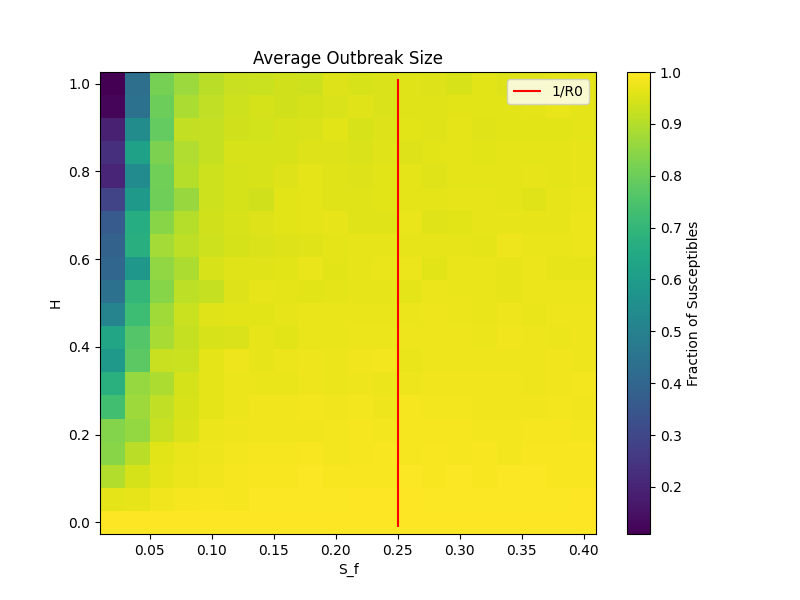

In [ ]:
# """
# Now simulate varying both sf (0 to 1) and labmda_edges, recording the mean cluster size and giant component
# """

N = 1000  # Number of nodes in the network
M = 30     # Size of the cliques

R0 = 4

p = R0/(R0+1)

N_H = 20
N_sf =  20

H_values = np.linspace(0, 1, N_H)
sf_values = np.linspace(0, 0.4, N_sf+1)[1:] #Eliminates the empty configuration

cluster_sizes = np.zeros((N_H, N_sf))
giant_component = np.zeros_like(cluster_sizes)

N_runs = 10

for _ in tqdm(range(N_runs), desc = "Nr. Runs Loop"):
    # Generate the adjacency matrix
    adj_matrix, cliques = generate_clustered_network_discrete_M(N, M, lambda_edges = 2, m_cliques= 2)
    #adj_matrix, cliques = generate_clustered_network(N, M, lambda_edges = 2, lambda_cliques = 2)
    for i, H_s in enumerate(H_values):
        for j, sf in enumerate(sf_values):
            adj_matrix_reduced = keep_clusters_with_node_swap(adj_matrix, cliques, s_f = sf, H = H_s)

            percolation_clusters, _,  percolation_giant = perform_percolation(adj_matrix_reduced, p = p, N_p = 10)

            cluster_sizes[i,j] += percolation_clusters/N_runs    
            giant_component[i,j] += percolation_giant/N_runs       

plt.figure(figsize=(8, 6))
X, Y = np.meshgrid(sf_values, H_values)
plt.pcolormesh(X, Y, giant_component)
plt.colorbar(label='Fraction of Susceptibles')
plt.ylabel("H")
plt.xlabel(f"S_f")
plt.title("Average Outbreak Size")
plt.vlines(1/R0, ymin = 0-.01, ymax = 1+.01, color = "red", label = f"1/R0")
plt.legend()
plt.show()

Nr. Runs Loop: 100%|██████████| 10/10 [05:11<00:00, 31.20s/it]


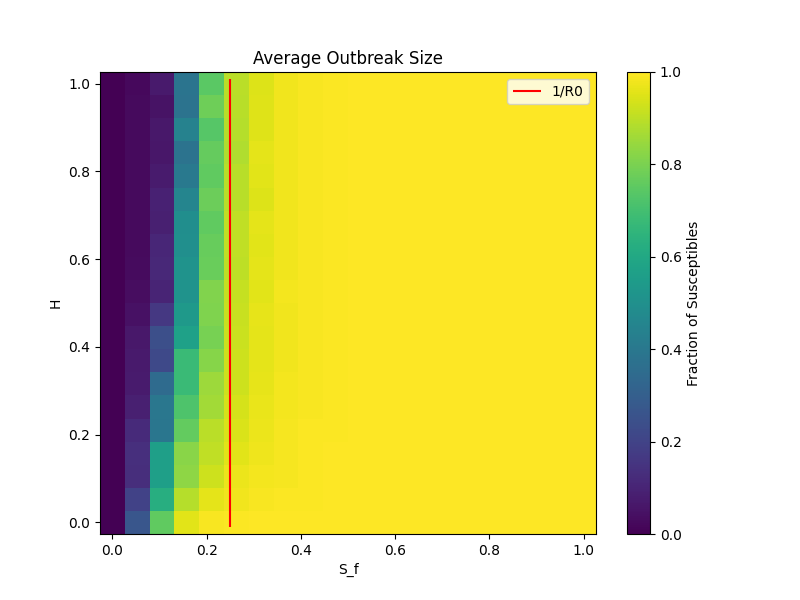

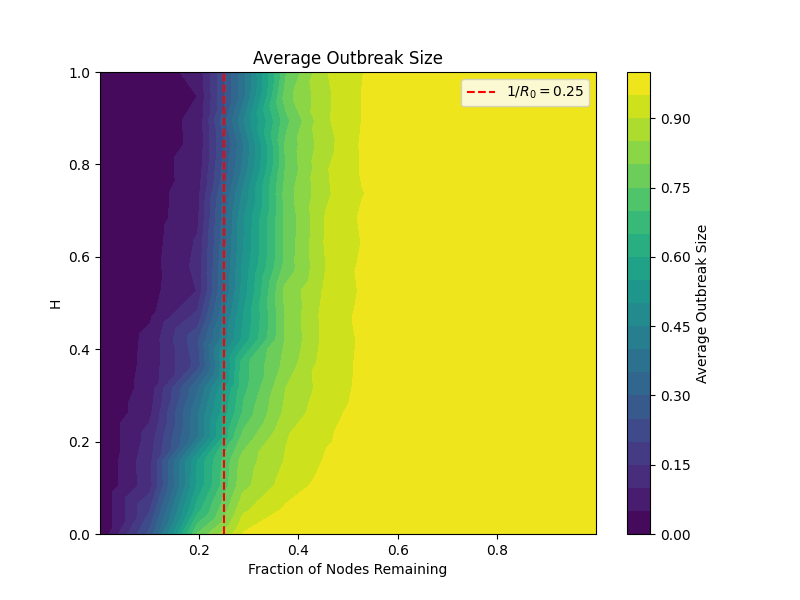

In [ ]:
# """
# Now simulate varying both sf (0 to 1) and labmda_edges, recording the mean cluster size and giant component
# """

N = 1000  # Number of nodes in the network
M = 4   # Size of the cliques

R0 = 4

p = R0/(R0+1)

N_H = 20
N_sf =  20

H_values = np.linspace(0, 1, N_H)
sf_values = np.linspace(0, 1, N_sf)#Eliminates the empty configuration

outbreak = np.zeros((N_H, N_sf,2))


N_runs = 10

for _ in tqdm(range(N_runs), desc = "Nr. Runs Loop"):
    # Generate the adjacency matrix
    adj_matrix, cliques = generate_clustered_network_discrete_M(N, M, lambda_edges = 2, m_cliques= 2)
    nr_nodes = np.shape(adj_matrix)[0]
    #adj_matrix, cliques = generate_clustered_network(N, M, lambda_edges = 2, lambda_cliques = 2)
    for i, H_s in enumerate(H_values):
        for j, sf in enumerate(sf_values):
            adj_matrix_reduced = keep_clusters_with_node_swap(adj_matrix, cliques, s_f = sf, H = H_s)

            nr_nodes_reduced = np.shape(adj_matrix_reduced)[0]

            outbreak_size = perform_percolation(adj_matrix_reduced, p = p, N_p = 10)

            outbreak[i,j,0] += outbreak_size/N_runs
            outbreak[i,j,1] += nr_nodes_reduced/(N_runs* nr_nodes)       

plt.figure(figsize=(8, 6))
X, Y = np.meshgrid(sf_values, H_values)
plt.pcolormesh(X, Y, outbreak[:,:,0])
plt.colorbar(label='Fraction of Susceptibles')
plt.ylabel("H")
plt.xlabel(f"S_f")
plt.title("Average Outbreak Size")
plt.vlines(1/R0, ymin = 0-.01, ymax = 1+.01, color = "red", label = f"1/R0")
plt.legend()
plt.show()

# Prepare data for plotting
X = outbreak[:, :, 1].flatten()  # Fraction of nodes remaining (x-axis)
Y = np.repeat(H_values, N_sf)    # H values (y-axis)
Z = outbreak[:, :, 0].flatten()  # Outbreak sizes (z-values)

# Create a triangulation
triang = tri.Triangulation(X, Y)

# Create contour plot
plt.figure(figsize=(8, 6))
contour = plt.tricontourf(triang, Z, levels=20, cmap='viridis')
plt.colorbar(contour, label='Average Outbreak Size')
plt.ylabel("H")
plt.xlabel("Fraction of Nodes Remaining")
plt.title("Average Outbreak Size")

# Add vertical line at 1/R0
plt.axvline(1 / R0, color='red', linestyle='--', label=r'$1/R_0 = {:.2f}$'.format(1 / R0))
plt.legend()

plt.show()

Nr. Runs Loop: 100%|██████████| 10/10 [04:42<00:00, 28.29s/it]


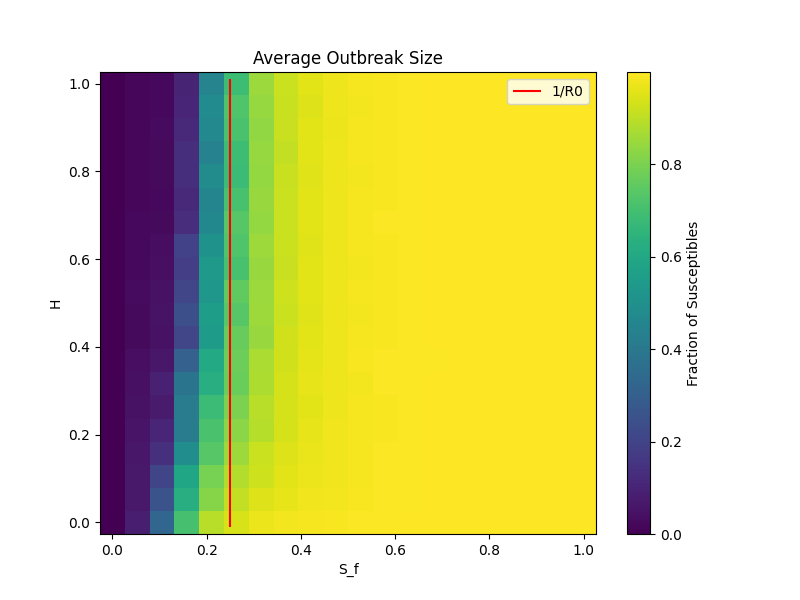

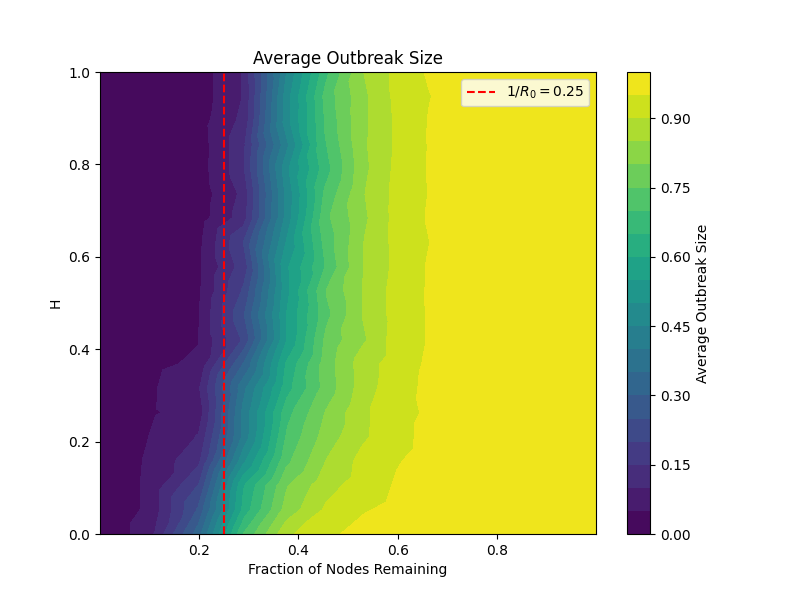

In [ ]:
# """
# Now simulate varying both sf (0 to 1) and labmda_edges, recording the mean cluster size and giant component
# """

N = 1000  # Number of nodes in the network
M = 3   # Size of the cliques

R0 = 4

p = R0/(R0+1)

N_H = 20
N_sf =  20

H_values = np.linspace(0, 1, N_H)
sf_values = np.linspace(0, 1, N_sf)#Eliminates the empty configuration

outbreak = np.zeros((N_H, N_sf,2))


N_runs = 10

for _ in tqdm(range(N_runs), desc = "Nr. Runs Loop"):
    # Generate the adjacency matrix
    adj_matrix, cliques = generate_clustered_network_discrete_M(N, M, lambda_edges = 2, m_cliques= 2)
    nr_nodes = np.shape(adj_matrix)[0]
    #adj_matrix, cliques = generate_clustered_network(N, M, lambda_edges = 2, lambda_cliques = 2)
    for i, H_s in enumerate(H_values):
        for j, sf in enumerate(sf_values):
            adj_matrix_reduced = keep_clusters_with_node_swap(adj_matrix, cliques, s_f = sf, H = H_s)

            nr_nodes_reduced = np.shape(adj_matrix_reduced)[0]

            outbreak_size = perform_percolation(adj_matrix_reduced, p = p, N_p = 10)

            outbreak[i,j,0] += outbreak_size/N_runs
            outbreak[i,j,1] += nr_nodes_reduced/(N_runs* nr_nodes)       

plt.figure(figsize=(8, 6))
X, Y = np.meshgrid(sf_values, H_values)
plt.pcolormesh(X, Y, outbreak[:,:,0])
plt.colorbar(label='Fraction of Susceptibles')
plt.ylabel("H")
plt.xlabel(f"S_f")
plt.title("Average Outbreak Size")
plt.vlines(1/R0, ymin = 0-.01, ymax = 1+.01, color = "red", label = f"1/R0")
plt.legend()
plt.show()

# Prepare data for plotting
X = outbreak[:, :, 1].flatten()  # Fraction of nodes remaining (x-axis)
Y = np.repeat(H_values, N_sf)    # H values (y-axis)
Z = outbreak[:, :, 0].flatten()  # Outbreak sizes (z-values)

# Create a triangulation
triang = tri.Triangulation(X, Y)

# Create contour plot
plt.figure(figsize=(8, 6))
contour = plt.tricontourf(triang, Z, levels=20, cmap='viridis')
plt.colorbar(contour, label='Average Outbreak Size')
plt.ylabel("H")
plt.xlabel("Fraction of Nodes Remaining")
plt.title("Average Outbreak Size")

# Add vertical line at 1/R0
plt.axvline(1 / R0, color='red', linestyle='--', label=r'$1/R_0 = {:.2f}$'.format(1 / R0))
plt.legend()

plt.show()

Nr. Runs Loop: 100%|██████████| 10/10 [03:48<00:00, 22.89s/it]


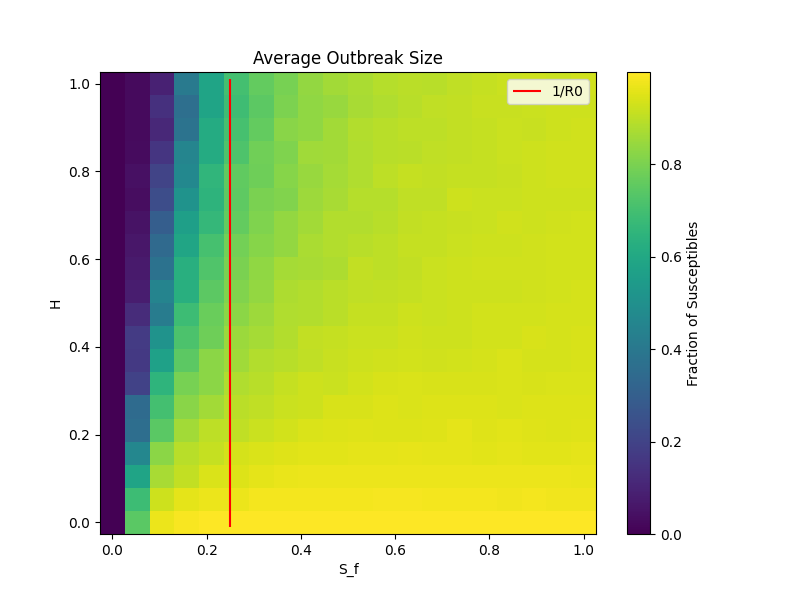

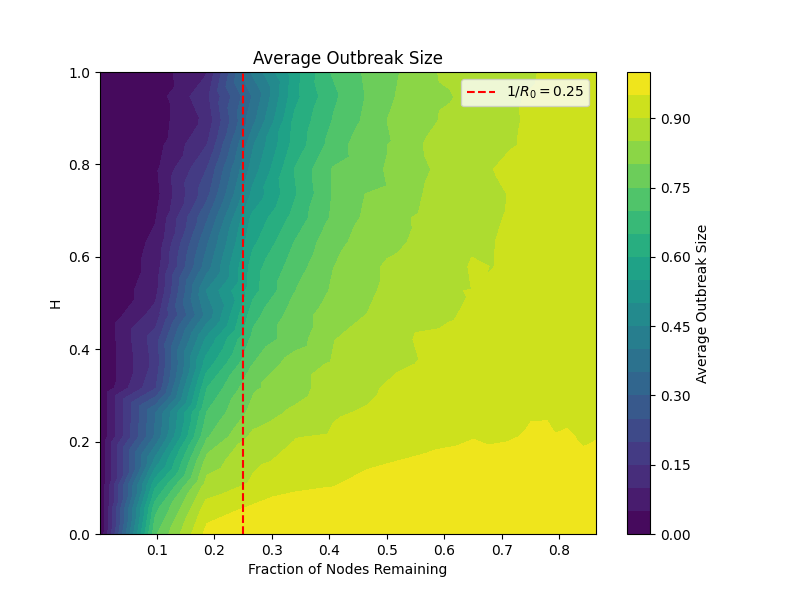

In [ ]:
# """
# Now simulate varying both sf (0 to 1) and labmda_edges, recording the mean cluster size and giant component
# """

N = 1000  # Number of nodes in the network
M = 4   # Size of the cliques

R0 = 4

p = R0/(R0+1)

N_H = 20
N_sf =  20

H_values = np.linspace(0, 1, N_H)
sf_values = np.linspace(0, 1, N_sf)#Eliminates the empty configuration

outbreak = np.zeros((N_H, N_sf,2))


N_runs = 10

for _ in tqdm(range(N_runs), desc = "Nr. Runs Loop"):
    # Generate the adjacency matrix
    #adj_matrix, cliques = generate_clustered_network_discrete_M(N, M, lambda_edges = 2, m_cliques= 2)
    adj_matrix, cliques = generate_clustered_network(N, M, lambda_edges = 2, lambda_cliques = 2)
    nr_nodes = np.shape(adj_matrix)[0]
    
    for i, H_s in enumerate(H_values):
        for j, sf in enumerate(sf_values):
            adj_matrix_reduced = keep_clusters_with_node_swap(adj_matrix, cliques, s_f = sf, H = H_s)

            nr_nodes_reduced = np.shape(adj_matrix_reduced)[0]

            outbreak_size = perform_percolation(adj_matrix_reduced, p = p, N_p = 10)

            outbreak[i,j,0] += outbreak_size/N_runs
            outbreak[i,j,1] += nr_nodes_reduced/(N_runs* nr_nodes)       

plt.figure(figsize=(8, 6))
X, Y = np.meshgrid(sf_values, H_values)
plt.pcolormesh(X, Y, outbreak[:,:,0])
plt.colorbar(label='Fraction of Susceptibles')
plt.ylabel("H")
plt.xlabel(f"S_f")
plt.title("Average Outbreak Size")
plt.vlines(1/R0, ymin = 0-.01, ymax = 1+.01, color = "red", label = f"1/R0")
plt.legend()
plt.show()

# Prepare data for plotting
X = outbreak[:, :, 1].flatten()  # Fraction of nodes remaining (x-axis)
Y = np.repeat(H_values, N_sf)    # H values (y-axis)
Z = outbreak[:, :, 0].flatten()  # Outbreak sizes (z-values)

# Create a triangulation
triang = tri.Triangulation(X, Y)

# Create contour plot
plt.figure(figsize=(8, 6))
contour = plt.tricontourf(triang, Z, levels=20, cmap='viridis')
plt.colorbar(contour, label='Average Outbreak Size')
plt.ylabel("H")
plt.xlabel("Fraction of Nodes Remaining")
plt.title("Average Outbreak Size")

# Add vertical line at 1/R0
plt.axvline(1 / R0, color='red', linestyle='--', label=r'$1/R_0 = {:.2f}$'.format(1 / R0))
plt.legend()

plt.show()

10it [00:39,  3.90s/it]
10it [00:42,  4.25s/it]
10it [00:43,  4.39s/it]
10it [00:42,  4.24s/it]
10it [00:48,  4.88s/it]
10it [00:44,  4.48s/it]
10it [00:39,  3.97s/it]
10it [00:48,  4.87s/it]
10it [00:38,  3.87s/it]
10it [00:41,  4.14s/it]


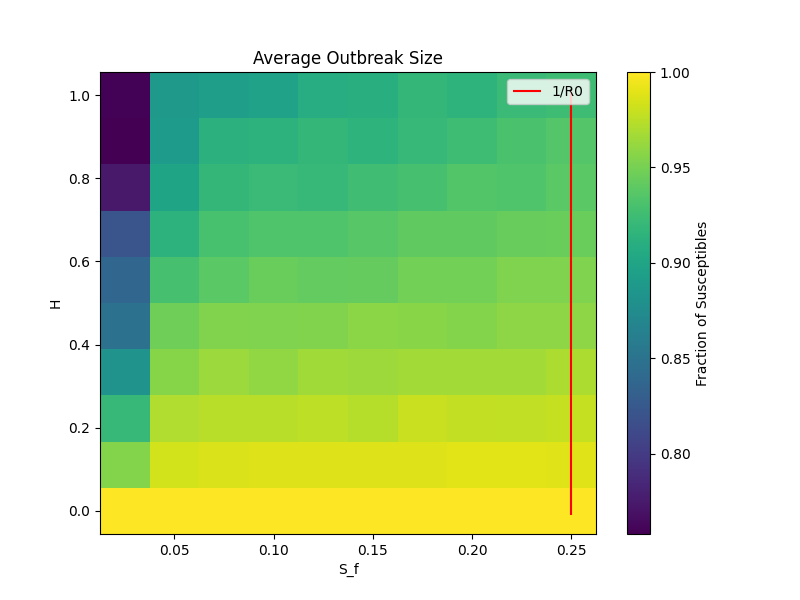

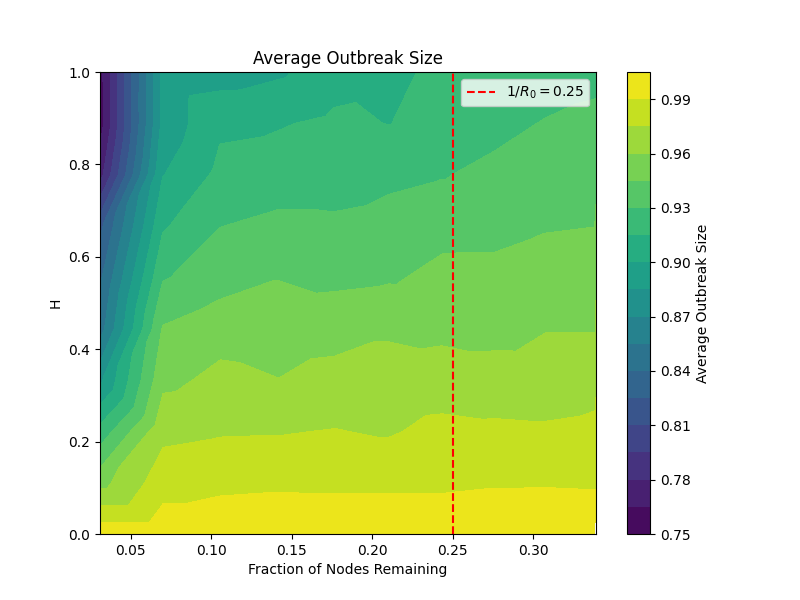

In [51]:
# """
# Now simulate varying both sf (0 to 1) and labmda_edges, recording the mean cluster size and giant component
# """

N = 10000  # Number of nodes in the network
M = 100   # Size of the cliques

R0 = 4

p = R0/(R0+1)

N_H = 10
N_sf =  10

H_values = np.linspace(0, 1, N_H)
sf_values = np.linspace(0, 0.25, N_sf+1)[1:]#Eliminates the empty configuration

outbreak = np.zeros((N_H, N_sf))
size_frac = np.zeros_like(outbreak)


N_runs = 10

for _ in range(N_runs):
    # Generate the adjacency matrix
    adj_matrix, cliques = generate_clustered_network_discrete_M(N, M, lambda_edges = 2, m_cliques= 2)
    nr_nodes = np.shape(adj_matrix)[0]
    for i, H_s in tqdm(enumerate(H_values)):
        for j, sf in enumerate(sf_values):
            adj_matrix_reduced = keep_clusters_with_node_swap(adj_matrix, cliques, s_f = sf, H = H_s)

            nr_nodes_reduced = np.shape(adj_matrix_reduced)[0]

            outbreak_size = perform_percolation(adj_matrix_reduced, p = p, N_p = 3)

            outbreak[i,j] += outbreak_size/N_runs
            size_frac[i,j] += nr_nodes_reduced/(N_runs* nr_nodes)       

plt.figure(figsize=(8, 6))
X, Y = np.meshgrid(sf_values, H_values)
plt.pcolormesh(X, Y, outbreak[:,:])
plt.colorbar(label='Fraction of Susceptibles')
plt.ylabel("H")
plt.xlabel(f"S_f")
plt.title("Average Outbreak Size")
plt.vlines(1/R0, ymin = 0-.01, ymax = 1+.01, color = "red", label = f"1/R0")
plt.legend()
plt.show()

# Prepare data for plotting
X = size_frac[:, :].flatten()  # Fraction of nodes remaining (x-axis)
Y = np.repeat(H_values, N_sf)    # H values (y-axis)
Z = outbreak[:, :].flatten()  # Outbreak sizes (z-values)

# Create a triangulation
triang = tri.Triangulation(X, Y)

# Create contour plot
plt.figure(figsize=(8, 6))
contour = plt.tricontourf(triang, Z, levels=20, cmap='viridis')
plt.colorbar(contour, label='Average Outbreak Size')
plt.ylabel("H")
plt.xlabel("Fraction of Nodes Remaining")
plt.title("Average Outbreak Size")

# Add vertical line at 1/R0
plt.axvline(1 / R0, color='red', linestyle='--', label=r'$1/R_0 = {:.2f}$'.format(1 / R0))
plt.legend()

plt.show()

In [12]:
N = 1000  # Number of nodes in the network
M = 3    # Size of the cliques

R0 = 4

p = R0/(R0+1)

N_H = 20
N_sf =  20

H_values = np.linspace(0, 1, N_H)
sf_values = np.linspace(0, 0.4, N_sf+1)[1:] #Eliminates the empty configuration

cluster_sizes = np.zeros((N_H, N_sf))
giant_component = np.zeros_like(cluster_sizes)

N_runs = 10

for _ in tqdm(range(N_runs), desc = "Nr. Runs Loop"):
    # Generate the adjacency matrix
    adj_matrix, cliques = generate_clustered_network_discrete_M(N, M, lambda_edges = 2, m_cliques= 2)
    #adj_matrix, cliques = generate_clustered_network(N, M, lambda_edges = 2, lambda_cliques = 2)
    for i, H_s in enumerate(H_values):
        for j, sf in enumerate(sf_values):
            adj_matrix_reduced = keep_clusters_with_node_swap(adj_matrix, cliques, s_f = sf, H = H_s)

            percolation_giant = perform_percolation(adj_matrix_reduced, p = p, N_p = 10)

            #cluster_sizes[i,j] += percolation_clusters/N_runs    
            giant_component[i,j] += percolation_giant/N_runs       

plt.figure(figsize=(8, 6))
X, Y = np.meshgrid(sf_values, H_values)
plt.pcolormesh(X, Y, giant_component)
plt.colorbar(label='Fraction of Susceptibles')
plt.ylabel("H")
plt.xlabel(f"S_f")
plt.title("Average Outbreak Size")
plt.vlines(1/R0, ymin = 0-.01, ymax = 1+.01, color = "red", label = f"1/R0")
plt.legend()
plt.show()

Nr. Runs Loop:  60%|██████    | 6/10 [01:49<01:12, 18.25s/it]


KeyboardInterrupt: 

Nr. Runs Loop: 100%|██████████| 10/10 [03:23<00:00, 20.34s/it]


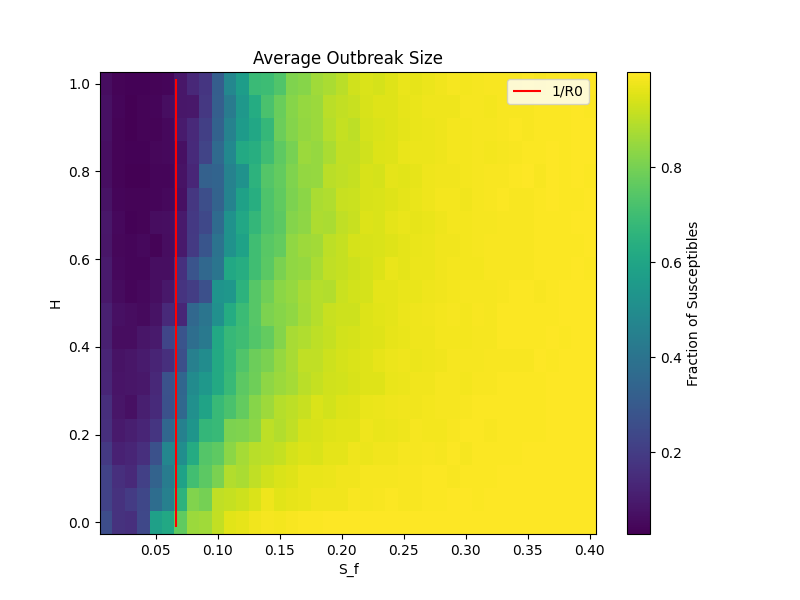

In [ ]:
N = 1000  # Number of nodes in the network
M = 3     # Size of the cliques

R0 = 15

p = R0/(R0+1)

N_H = 20
N_sf =  40

H_values = np.linspace(0, 1, N_H)
sf_values = np.linspace(0, 0.4, N_sf+1)[1:] #Eliminates the empty configuration

giant_component = np.zeros((N_H, N_sf))

N_runs = 10

for _ in tqdm(range(N_runs), desc = "Nr. Runs Loop"):
    # Generate the adjacency matrix
    adj_matrix, cliques = generate_clustered_network_discrete_M(N, M, lambda_edges = 5, m_cliques= 2)
    #adj_matrix, cliques = generate_clustered_network(N, M, lambda_edges = 2, lambda_cliques = 2)
    for i, H_s in enumerate(H_values):
        for j, sf in enumerate(sf_values):
            adj_matrix_reduced = keep_clusters_with_node_swap(adj_matrix, cliques, s_f = sf, H = H_s)

            percolation_giant = perform_percolation(adj_matrix_reduced, p = p, N_p = 10)

            giant_component[i,j] += percolation_giant/N_runs       

plt.figure(figsize=(8, 6))
X, Y = np.meshgrid(sf_values, H_values)
plt.pcolormesh(X, Y, giant_component)
plt.colorbar(label='Fraction of Susceptibles')
plt.ylabel("H")
plt.xlabel(f"S_f")
plt.title("Average Outbreak Size")
plt.vlines(1/R0, ymin = 0-.01, ymax = 1+.01, color = "red", label = f"1/R0")
plt.legend()
plt.show()

Nr. Runs Loop: 100%|██████████| 10/10 [02:34<00:00, 15.43s/it]


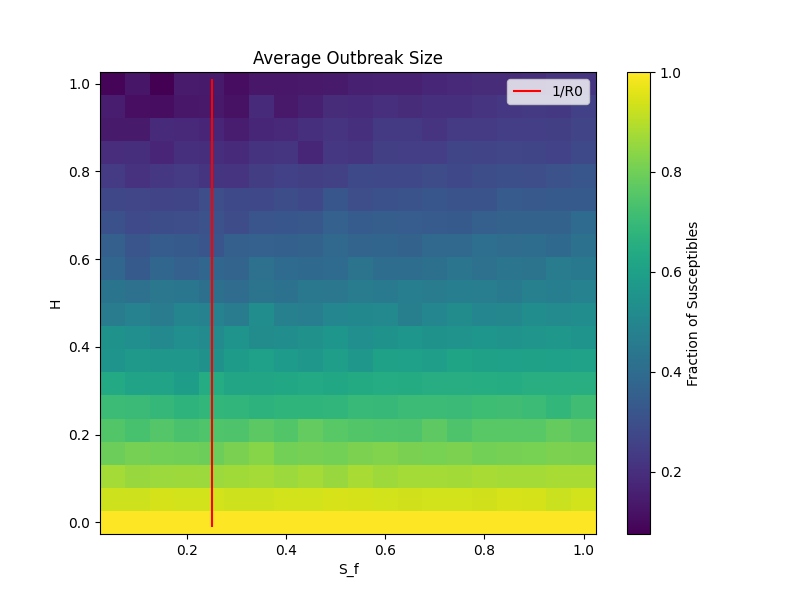

In [ ]:
# """
# Now simulate varying both sf (0 to 1) and labmda_edges, recording the mean cluster size and giant component
# """

N = 1000  # Number of nodes in the network
M = 80    # Size of the cliques

R0 = 4

p = R0/(R0+1)

N_H = 20
N_sf =  20

H_values = np.linspace(0, 1, N_H)
sf_values = np.linspace(0, 1, N_sf+1)[1:] #Eliminates the empty configuration

cluster_sizes = np.zeros((N_H, N_sf))
giant_component = np.zeros_like(cluster_sizes)

N_runs = 10

for _ in tqdm(range(N_runs), desc = "Nr. Runs Loop"):
    # Generate the adjacency matrix
    adj_matrix, cliques = generate_clustered_network_discrete_M(N, M, lambda_edges = 2, m_cliques= 2)
    #adj_matrix, cliques = generate_clustered_network(N, M, lambda_edges = 2, lambda_cliques = 2)
    for i, H_s in enumerate(H_values):
        for j, sf in enumerate(sf_values):
            adj_matrix_reduced = keep_clusters_with_node_swap(adj_matrix, cliques, s_f = sf, H = H_s)

            percolation_clusters, _,  percolation_giant = perform_percolation(adj_matrix_reduced, p = p, N_p = 10)

            cluster_sizes[i,j] += percolation_clusters/N_runs    
            giant_component[i,j] += percolation_giant/N_runs       

plt.figure(figsize=(8, 6))
X, Y = np.meshgrid(sf_values, H_values)
plt.pcolormesh(X, Y, giant_component)
plt.colorbar(label='Fraction of Susceptibles')
plt.ylabel("H")
plt.xlabel(f"S_f")
plt.title("Average Outbreak Size")
plt.vlines(1/R0, ymin = 0-.01, ymax = 1+.01, color = "red", label = f"1/R0")
plt.legend()
plt.show()

Bigger clusters give more exact estimate of $1/R0$ boundary 

Perc. Param. Loop: 100%|██████████| 20/20 [05:08<00:00, 15.40s/it]


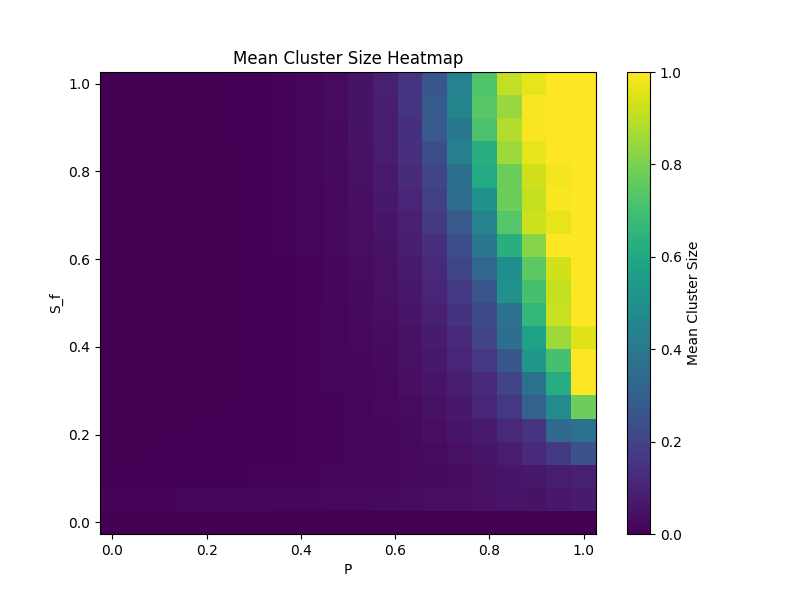

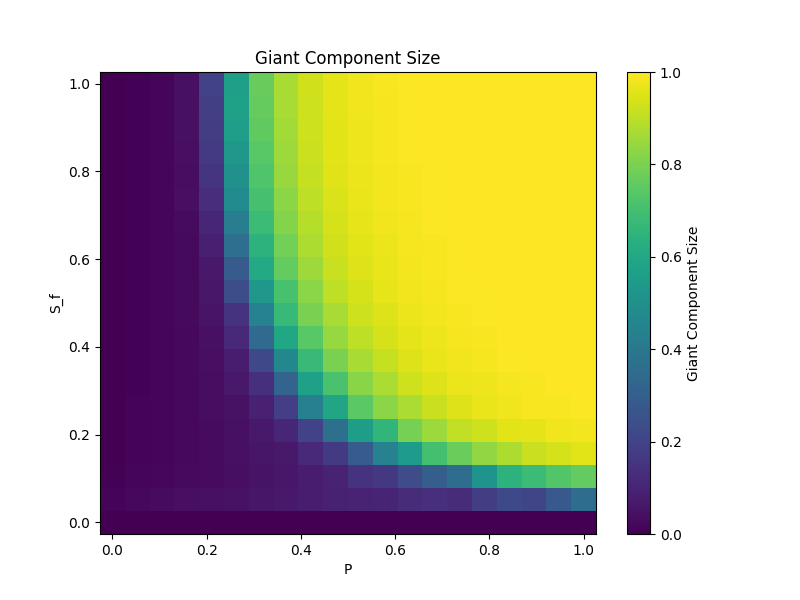

In [ ]:
"""
Now simulate varying both sf (0 to 1) and percolation parameter (0,1), recording the mean cluster size and giant component
"""

N = 1000   # Number of nodes in the network
M = 3    # Size of the cliques

N_perc= 20
N_sf =  20


p_values = np.linspace(0, 1, N_perc)
sf_values = np.linspace(0, 1, N_sf)

cluster_sizes = np.zeros((N_sf, N_perc))
giant_component = np.zeros_like(cluster_sizes)
for i, p_vals in tqdm(enumerate(p_values), total=N_perc, desc="Perc. Param. Loop"):
    clusters = []
    giant_comp = []
    for _ in range(10):
        # Generate the adjacency matrix
        adj_matrix, cliques, nr_cliques = generate_clustered_network_discrete_M(N, M, lambda_edges = 2, m_cliques= 2, nr_cliques = True)
        intermediate_cluster = []
        intermediate_giant = []
        #print(nr_cliques)
        for sf in sf_values:
            adj_matrix_reduced = keep_clusters(adj_matrix, cliques, s_f = sf)

            percolation_clusters, percolation_giant = perform_percolation(adj_matrix_reduced, p = p_vals, N_p = 10)

            intermediate_cluster.append(percolation_clusters)        
            intermediate_giant.append(percolation_giant)        
        clusters.append(intermediate_cluster)
        giant_comp.append(intermediate_giant)
    cluster_sizes[: , i] = np.mean(clusters,axis = 0)
    giant_component[: , i] = np.mean(giant_comp,axis = 0)

plt.figure(figsize=(8, 6))
X, Y = np.meshgrid(p_values, sf_values)
plt.pcolormesh(X, Y, cluster_sizes)
plt.colorbar(label='Mean Cluster Size')
plt.xlabel("P")
plt.ylabel("S_f")
plt.title("Mean Cluster Size Heatmap")
plt.show()

plt.figure(figsize=(8, 6))
X, Y = np.meshgrid(p_values, sf_values)
plt.pcolormesh(X, Y, giant_component)
plt.colorbar(label='Giant Component Size')
plt.xlabel("P")
plt.ylabel("S_f")
plt.title("Giant Component Size")
plt.show()

Percolation Progress:   0%|          | 0/101 [00:00<?, ?it/s]

Percolation Progress: 100%|██████████| 101/101 [00:15<00:00,  6.71it/s]


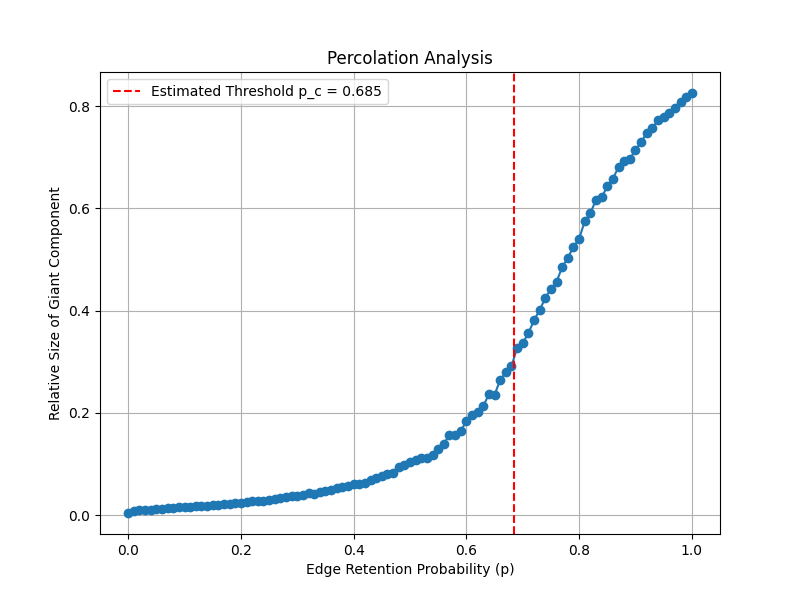

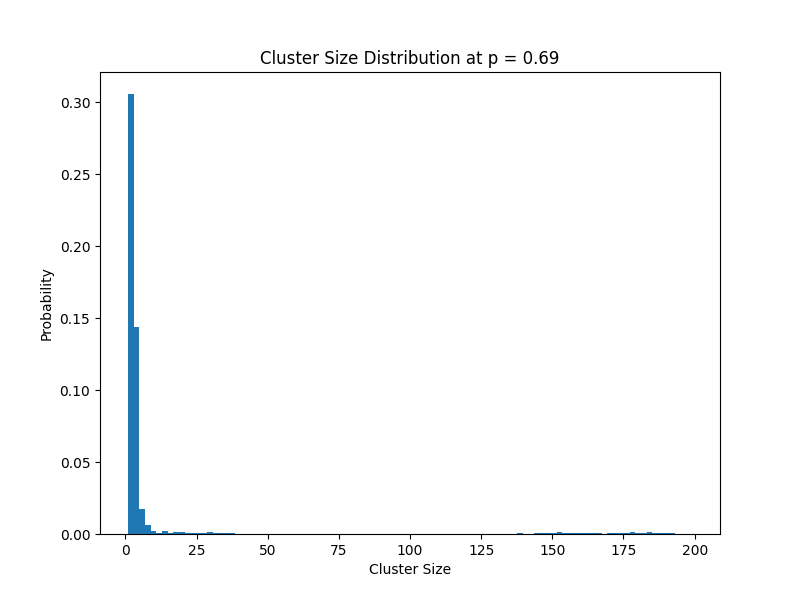

In [ ]:
# Assume adj_matrix is obtained from the previous function generate_clustered_network
N = 1000
M = 3
adj_matrix, cliques = generate_clustered_network_discrete_M(N, M, lambda_edges= 2, m_cliques= 2)
adj_matrix = keep_clusters_with_node_swap(adj_matrix=adj_matrix, cliques=cliques, s_f=1/8, H = 0.1)

# Define percolation parameters
N_p = 200  # Number of trials per p
p_values = np.linspace(0.0, 1.0, 101)  # Edge retention probabilities from 0 to 1

# Perform bond percolation
percolation_results = perform_bond_percolation(adj_matrix, N_p, p_values)

# Plot the size of the giant component vs. p
plt.figure(figsize=(8, 6))
plt.plot(percolation_results['p_values'], percolation_results['giant_component_sizes'], marker='o')
plt.axvline(percolation_results['percolation_threshold'], color='r', linestyle='--', label=f'Estimated Threshold p_c = {percolation_results["percolation_threshold"]:.3f}')
plt.title('Percolation Analysis')
plt.xlabel('Edge Retention Probability (p)')
plt.ylabel('Relative Size of Giant Component')
plt.legend()
plt.grid(True)
plt.show()

# Optionally, plot the cluster size distribution at the percolation threshold
p_c_index = np.argmin(np.abs(percolation_results['p_values'] - percolation_results['percolation_threshold']))
cluster_sizes_at_pc = percolation_results['cluster_size_distributions'][p_c_index+20]

plt.figure(figsize=(8, 6))
plt.hist(cluster_sizes_at_pc, bins = 100, density=True)
plt.title(f'Cluster Size Distribution at p = {percolation_results["p_values"][p_c_index]:.2f}')
plt.xlabel('Cluster Size')
plt.ylabel('Probability')
plt.show()


# What to ask now
- Can we produce the same analytical results as in Miller and Newman papers?
- How do we conduct the vaccination scheme (so how does clustering change outbreak prop - what fraction are in large cluster sizes/outbraks)?
    - This could involve picking uniformly to clusters in some way, and vaccinating/not vaccinating whole cliques, effectivly removing them from the graph
- As the mean number of M-cliques pr. nodes changes, how does the percolation parameter do so?
- Uniformly remove s nodes, vary "cliqueness" and record average outbreaksize.
- We should simulate results with cliques against simualtions with the same total degree without cliques



Remember we are assuming memmory-less (Markov property) and exponetially distributed waiting times to use $p_{infect} = \beta/(\beta+\nu)$

we should just jsut require self loops and isolated nodes to be discarded.